# Plant Health Classification: Fresh vs Dry Using Spectral Data

### Dataset:
[Multi Spectral & Hyperspectral Image Dataset](https://figshare.com/articles/dataset/_b_A_multi-spectral_and_hyperspectral_image_dataset_for_evaluating_the_health_status_of_avocado_olive_and_vineyard_b_/26950660?file=49034797)


In [74]:
!wget https://github.com/p-p-p-p/Spectral-Data-Analysis/raw/refs/heads/main/spectral_data.csv
!wget https://github.com/p-p-p-p/Spectral-Data-Analysis/raw/refs/heads/main/dry_fresh_final_model.pkl

--2024-11-25 16:23:10--  https://github.com/p-p-p-p/Spectral-Data-Analysis/raw/refs/heads/main/spectral_data.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/p-p-p-p/Spectral-Data-Analysis/refs/heads/main/spectral_data.csv [following]
--2024-11-25 16:23:11--  https://raw.githubusercontent.com/p-p-p-p/Spectral-Data-Analysis/refs/heads/main/spectral_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7920826 (7.6M) [text/plain]
Saving to: ‘spectral_data.csv.1’

spectral_data.csv.1 100%[===================>]   7.55M  --.-KB/s    in 0.08s   

2024-11-25 16:23:11 (100 MB/s) - ‘spectral_data.c

## Step 1: Load the Dataset
#### Goal
The first step is to load the spectral data CSV file into a pandas DataFrame for further analysis.

#### Explanation
We will read the dataset from a CSV file (spectral_data.csv) and check for any missing values in the dataset. This helps in understanding the structure of the data and ensures that we have clean data for analysis.

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv('spectral_data.csv')

# EDA: Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())



Missing Values per Column:
0             0
1             0
2             0
3             0
4             0
             ..
2148          0
2149          0
2150          0
fruit_name    0
is_fresh      0
Length: 2153, dtype: int64


## Step 2: Shuffle the Dataset
#### Goal
We shuffle the dataset to ensure that the training and test sets are randomly sampled, preventing any bias that could arise from the order of the data.

#### Explanation
Shuffling the dataset randomly resets the index, ensuring that the data is in a random order before we proceed with any analysis or model training.

In [6]:
# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,2143,2144,2145,2146,2147,2148,2149,2150,fruit_name,is_fresh
0,0.140,0.134,0.129,0.133,0.130,0.119,0.110,0.103,0.101,0.104,...,0.235,0.231,0.231,0.231,0.229,0.226,0.224,0.226,vineyard,0
1,0.239,0.240,0.232,0.231,0.235,0.236,0.224,0.216,0.216,0.219,...,0.272,0.267,0.261,0.259,0.259,0.262,0.269,0.272,vineyard,0
2,0.260,0.264,0.263,0.251,0.243,0.241,0.232,0.232,0.233,0.231,...,0.314,0.317,0.310,0.311,0.318,0.317,0.326,0.331,olive,0
3,0.219,0.215,0.210,0.202,0.199,0.199,0.190,0.185,0.178,0.167,...,0.297,0.292,0.286,0.285,0.288,0.292,0.291,0.295,olive,0
4,0.225,0.233,0.244,0.219,0.202,0.214,0.234,0.216,0.186,0.172,...,0.335,0.335,0.337,0.338,0.335,0.336,0.339,0.334,vineyard,0


## Step 3: Explore Class Distribution
#### Goal
We aim to understand the distribution of the is_fresh class (whether the sample is fresh or dry) in the dataset.

#### Explanation
By analyzing the distribution of the is_fresh column, we can identify whether the classes are imbalanced, which might require us to apply techniques like oversampling or undersampling later.

<ipython-input-7-9b107f0e7753>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


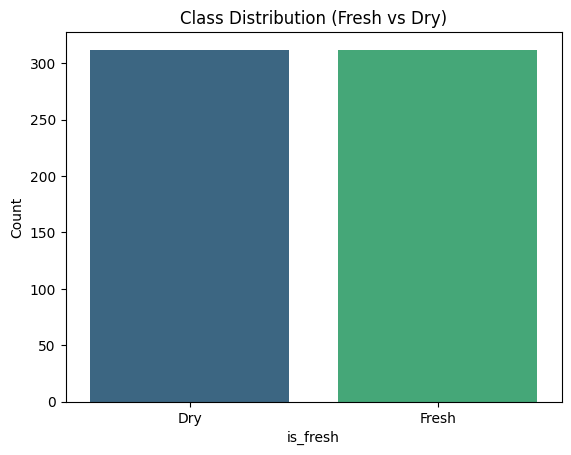

In [7]:
# Analyze class distribution
class_counts = df['is_fresh'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution (Fresh vs Dry)")
plt.xlabel("is_fresh")
plt.ylabel("Count")
plt.xticks([0, 1], ['Dry', 'Fresh'])
plt.show()


## Step 4: Plot Average Reflection Across All Wavelengths
#### Goal
Visualize the average reflection of the spectral data across all wavelengths.

#### Explanation
We compute the average reflection values for each wavelength across all samples (excluding fruit_name and is_fresh). The plot will help us see how the average reflection varies with wavelength.

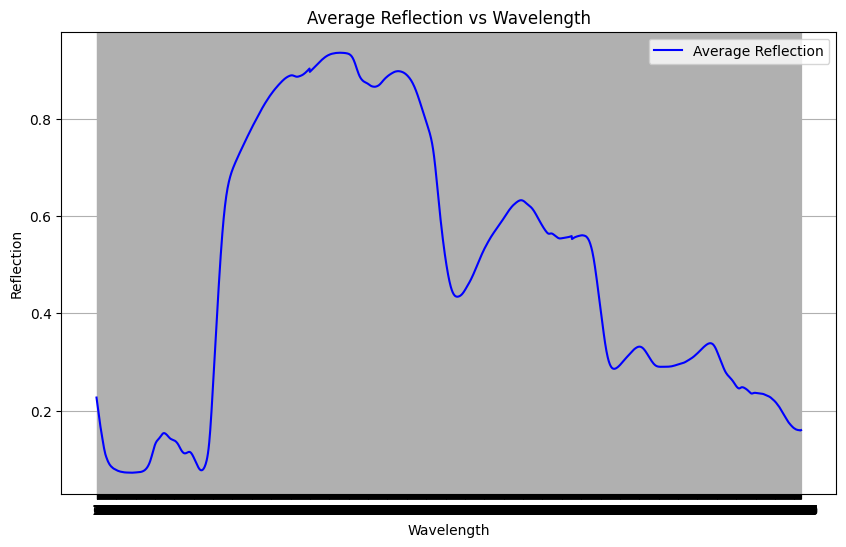

In [9]:
import matplotlib.pyplot as plt

# Assuming the first column corresponds to wavelengths and the remaining columns are the reflection values
wavelengths = df.columns[:-2]  # Exclude 'fruit_name' and 'is_fresh' columns if they exist
reflection_values = df.iloc[:, :-2].mean(axis=0)  # Average reflection values across all samples

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, reflection_values, label="Average Reflection", color='b')
plt.title("Average Reflection vs Wavelength")
plt.xlabel("Wavelength")
plt.ylabel("Reflection")
plt.grid(True)
plt.legend()
plt.show()


## Step 5: Plot Reflection vs Wavelength for Fresh and Dry Samples
#### Goal
Visualize the reflection values across different wavelengths for both fresh and dry samples.

#### Explanation
We separate the dataset into fresh and dry samples using the is_fresh column, then plot the average reflection for both groups within different wavelength ranges to see how they differ.

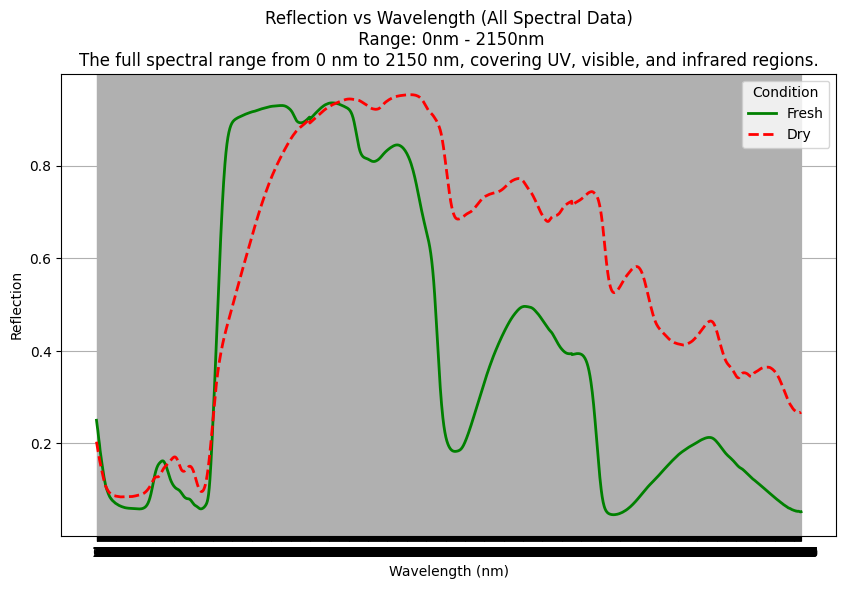

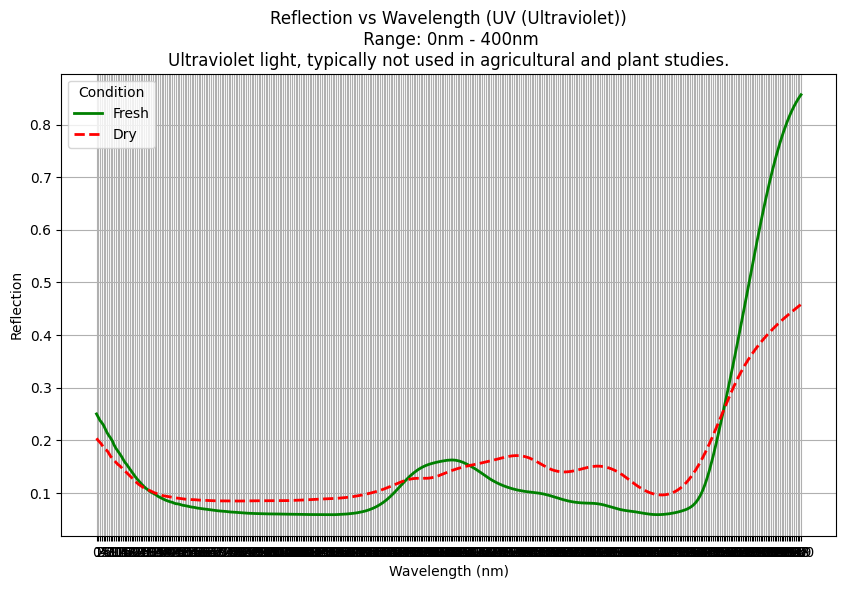

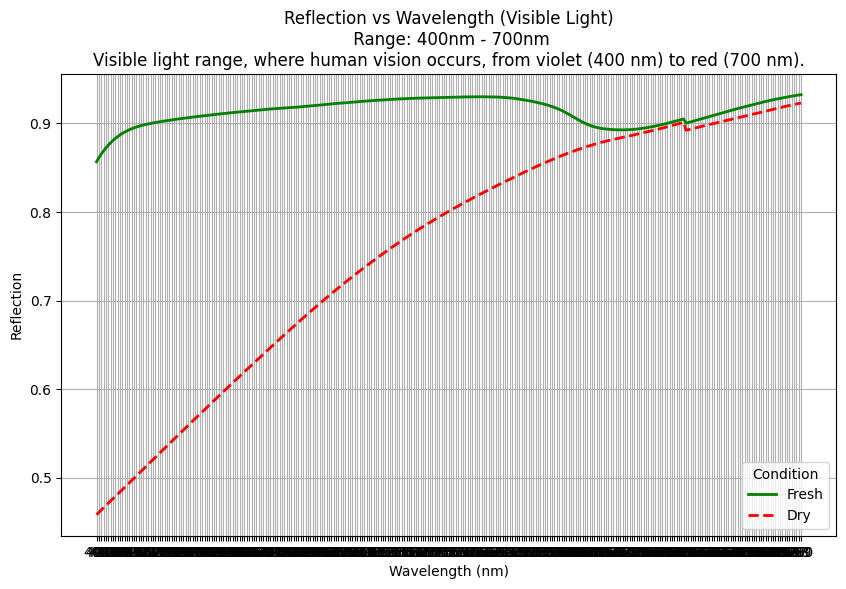

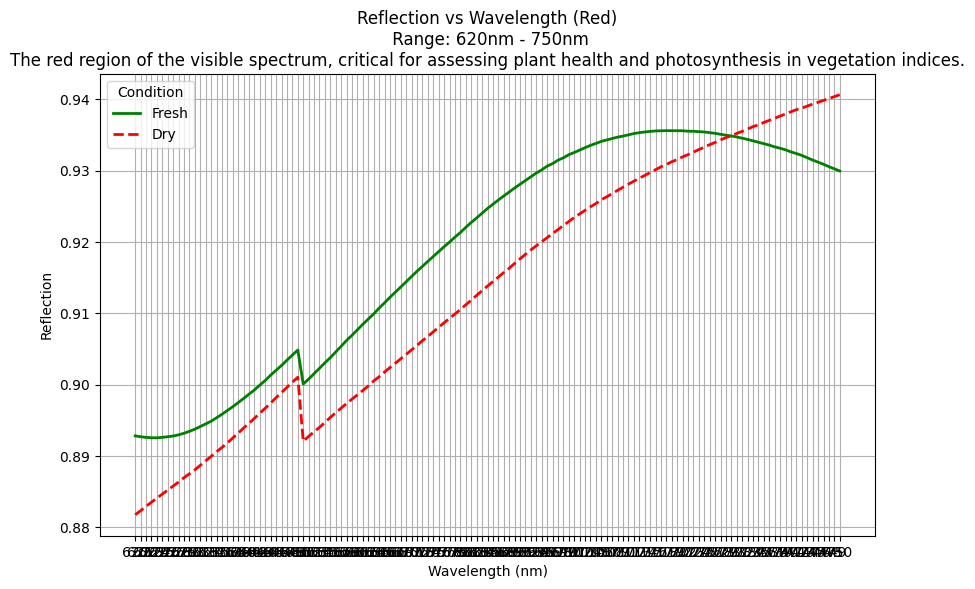

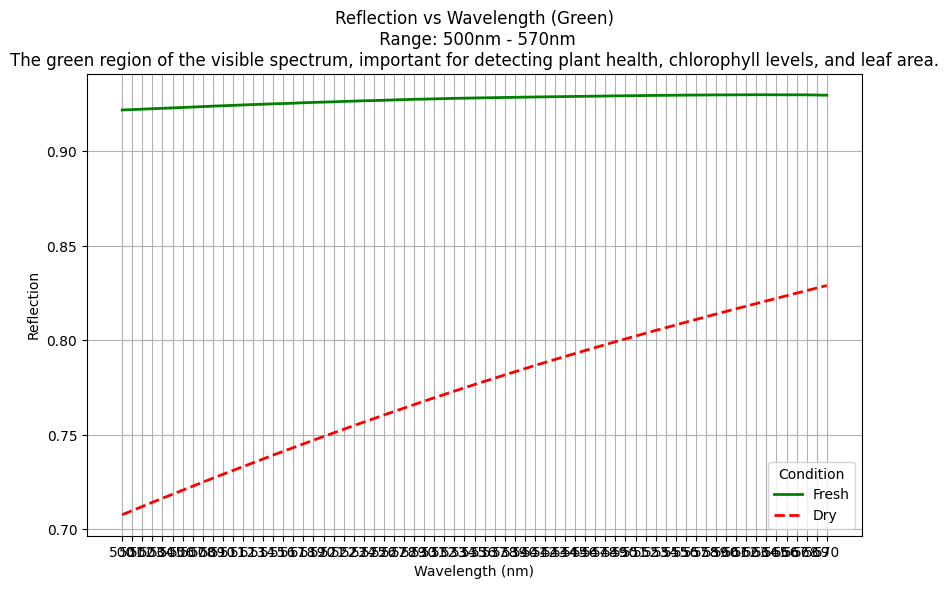

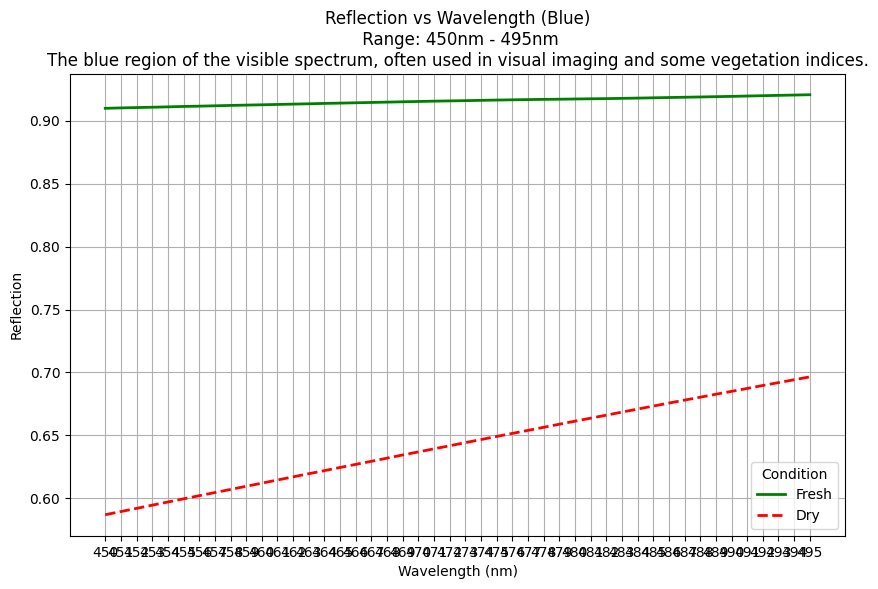

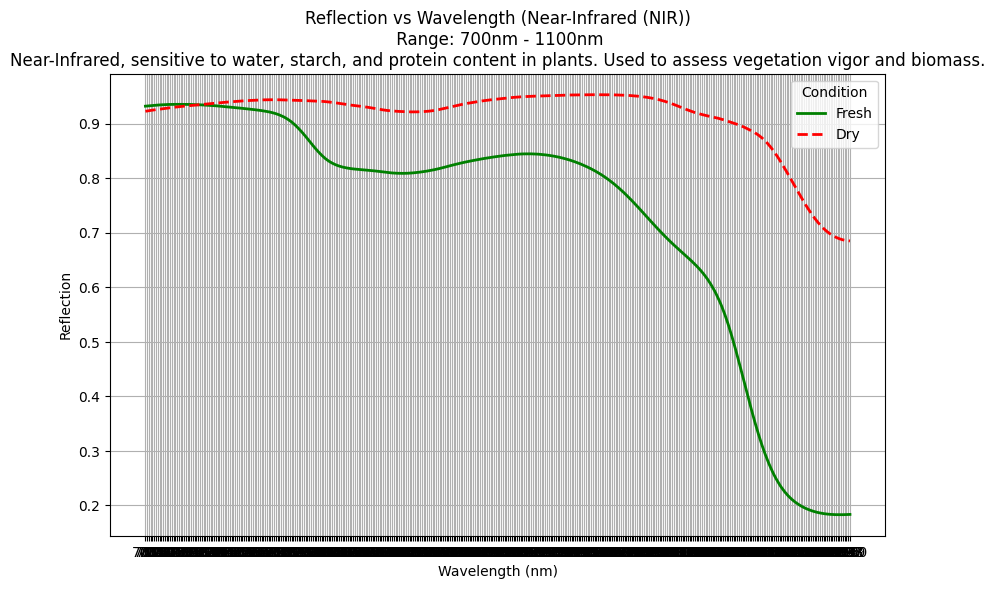

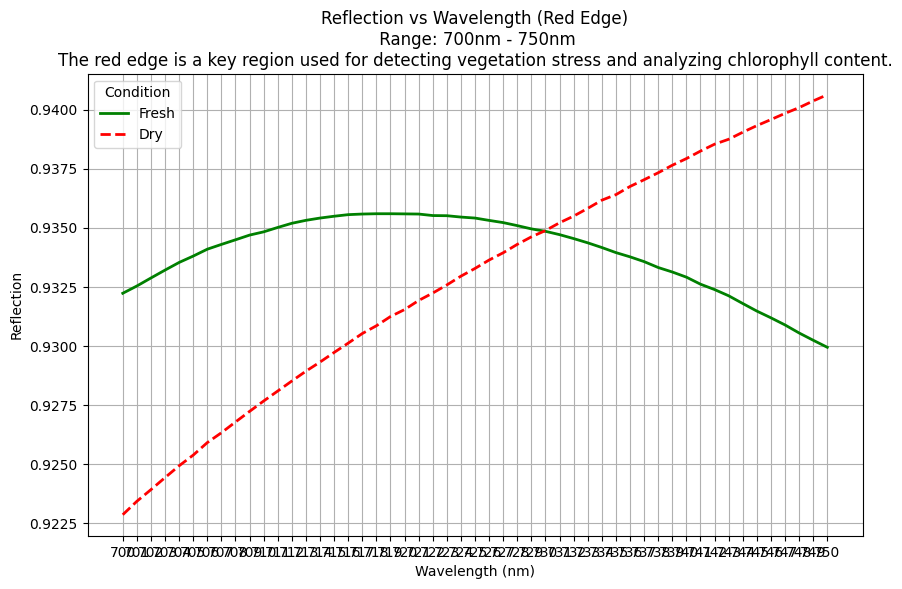

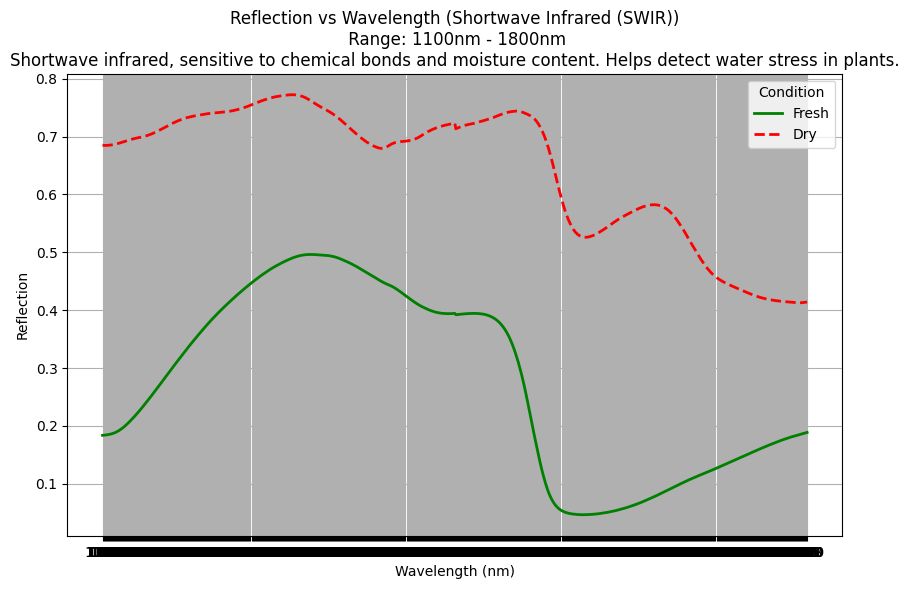

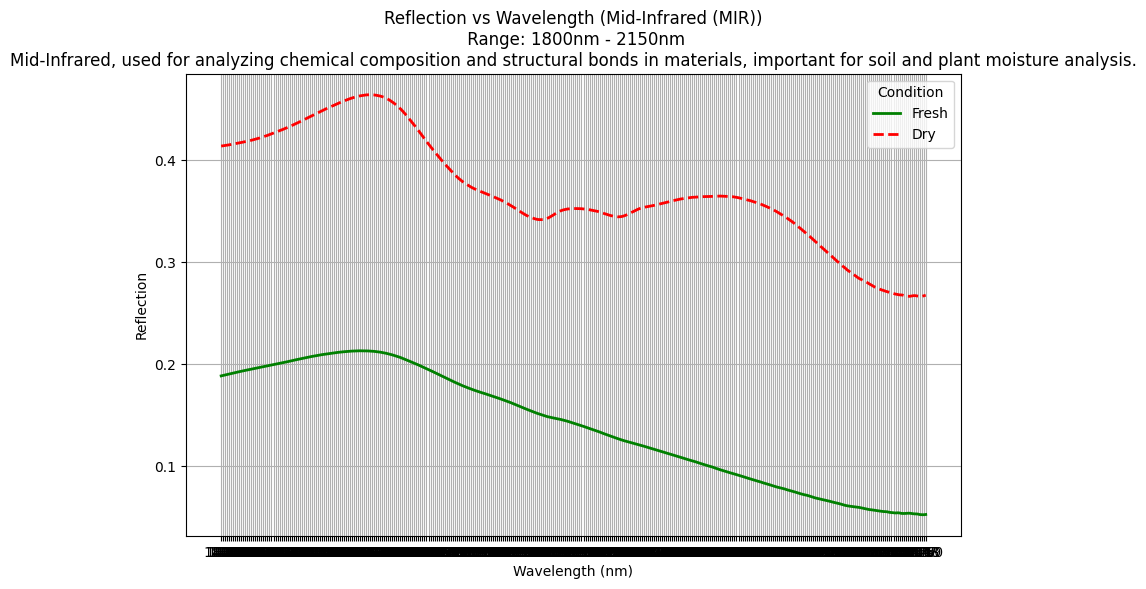

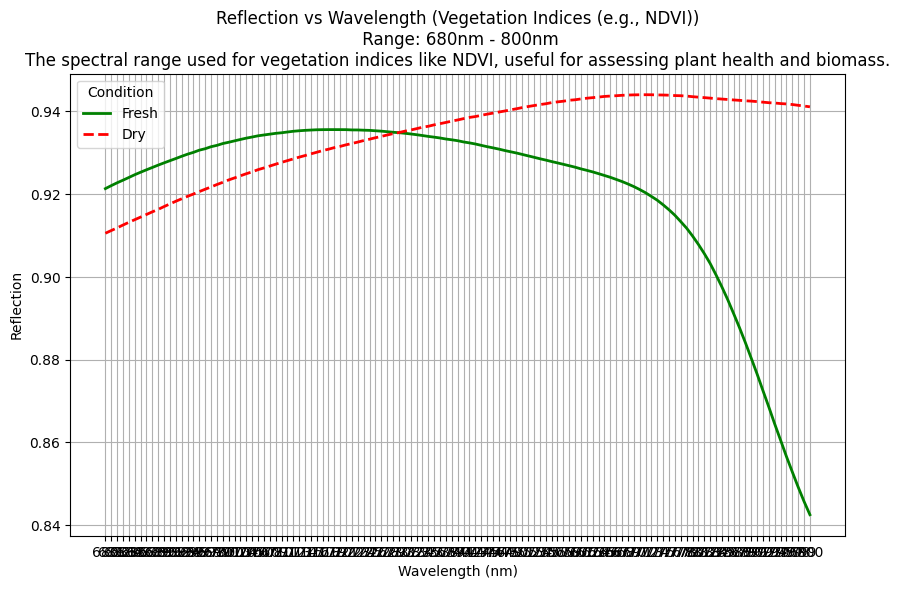

In [10]:
#@title Reflection vs Wavelength for Different Wavelength Range
# Function to plot reflection vs wavelength for fresh and dry samples based on a given wavelength range
def plot_spectral_data_by_range(df, wavelength_ranges):
    # Separate the data into fresh and dry samples based on the 'is_fresh' column
    fresh_data = df[df['is_fresh'] == 1]  # 'is_fresh' == 1 represents fresh samples
    dry_data = df[df['is_fresh'] == 0]    # 'is_fresh' == 0 represents dry samples

    # Assuming the first columns are wavelengths, and the rest are spectral reflection values
    wavelengths = df.columns[:-2]  # Exclude 'fruit_name' and 'is_fresh'

    # Loop through each range in the wavelength_ranges
    for range_name, range_values in wavelength_ranges.items():
        start = range_values["start"]
        end = range_values["end"]
        description = range_values["description"]

        # Find the corresponding columns for the given wavelength range
        valid_columns = [w for w in wavelengths if start <= int(w) <= end]

        # Calculate the average reflection values for fresh and dry samples within the range
        fresh_reflection = fresh_data[valid_columns].mean(axis=0)
        dry_reflection = dry_data[valid_columns].mean(axis=0)

        # Plotting the reflection vs. wavelength for fresh and dry samples within the given range
        plt.figure(figsize=(10, 6))
        plt.plot(valid_columns, fresh_reflection, label="Fresh", color='g', linestyle='-', linewidth=2)
        plt.plot(valid_columns, dry_reflection, label="Dry", color='r', linestyle='--', linewidth=2)

        # Adding labels and title
        plt.title(f"Reflection vs Wavelength ({range_name})\n Range: {start}nm - {end}nm\n{description}")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflection")
        plt.legend(title="Condition")
        plt.grid(True)
        plt.show()


# Wavelength ranges dictionary
wavelength_ranges = {
    "All Spectral Data": {
        "start": 0,
        "end": 2150,
        "description": "The full spectral range from 0 nm to 2150 nm, covering UV, visible, and infrared regions."
    },
    "UV (Ultraviolet)": {
        "start": 0,
        "end": 400,
        "description": "Ultraviolet light, typically not used in agricultural and plant studies."
    },
    "Visible Light": {
        "start": 400,
        "end": 700,
        "description": "Visible light range, where human vision occurs, from violet (400 nm) to red (700 nm)."
    },
    "Red": {
        "start": 620,
        "end": 750,
        "description": "The red region of the visible spectrum, critical for assessing plant health and photosynthesis in vegetation indices."
    },
    "Green": {
        "start": 500,
        "end": 570,
        "description": "The green region of the visible spectrum, important for detecting plant health, chlorophyll levels, and leaf area."
    },
    "Blue": {
        "start": 450,
        "end": 495,
        "description": "The blue region of the visible spectrum, often used in visual imaging and some vegetation indices."
    },
    "Near-Infrared (NIR)": {
        "start": 700,
        "end": 1100,
        "description": "Near-Infrared, sensitive to water, starch, and protein content in plants. Used to assess vegetation vigor and biomass."
    },
    "Red Edge": {
        "start": 700,
        "end": 750,
        "description": "The red edge is a key region used for detecting vegetation stress and analyzing chlorophyll content."
    },
    "Shortwave Infrared (SWIR)": {
        "start": 1100,
        "end": 1800,
        "description": "Shortwave infrared, sensitive to chemical bonds and moisture content. Helps detect water stress in plants."
    },
    "Mid-Infrared (MIR)": {
        "start": 1800,
        "end": 2150,
        "description": "Mid-Infrared, used for analyzing chemical composition and structural bonds in materials, important for soil and plant moisture analysis."
    },
    "Vegetation Indices (e.g., NDVI)": {
        "start": 680,
        "end": 800,
        "description": "The spectral range used for vegetation indices like NDVI, useful for assessing plant health and biomass."
    }
}
plot_spectral_data_by_range(df, wavelength_ranges)

## Step 6: Principal Component Analysis (PCA)
#### Goal
Reduce the dimensionality of the spectral data to visualize the relationship between fresh and dry samples.

#### Explanation
By performing PCA, we can project the high-dimensional spectral data into lower dimensions (e.g., 2 or 3), making it easier to visualize patterns such as clusters for fresh vs. dry samples.

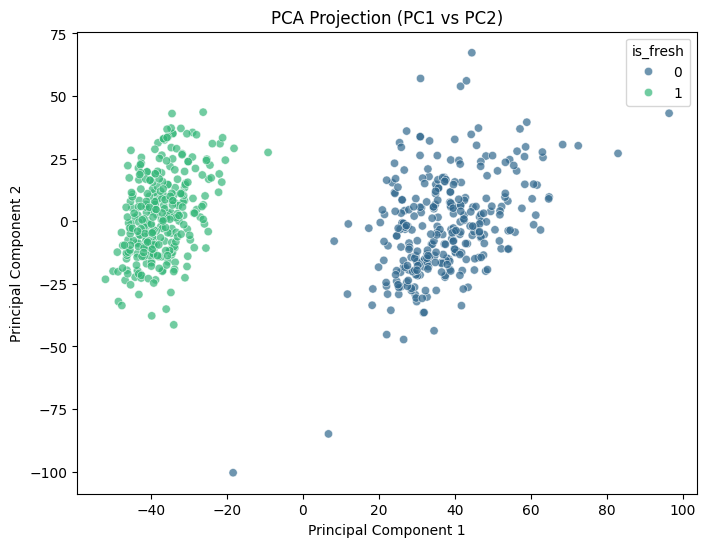

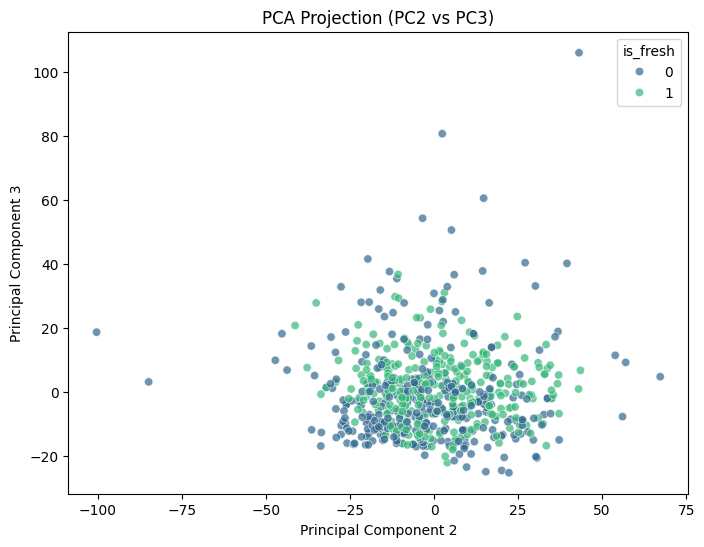

In [11]:
from sklearn.decomposition import PCA
import seaborn as sns

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.iloc[:, :-2])

# Perform PCA to reduce the data to 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Visualize PCA (PC1 vs PC2)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['is_fresh'], palette="viridis", alpha=0.7)
plt.title("PCA Projection (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="is_fresh", loc="upper right")
plt.show()

# Visualize PCA (PC2 vs PC3)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=df['is_fresh'], palette="viridis", alpha=0.7)
plt.title("PCA Projection (PC2 vs PC3)")
plt.xlabel("Principal Component 2")
plt.ylabel("Principal Component 3")
plt.legend(title="is_fresh", loc="upper right")
plt.show()


## Step 7: Model Training and Evaluation
#### Goal
Train machine learning models to classify the spectral data as fresh or dry, and evaluate their performance.

#### Explanation
We will train three different machine learning models: Random Forest, Logistic Regression, and Gradient Boosting. After training, we will evaluate the models using accuracy, ROC AUC score, and confusion matrix.


Random Forest Accuracy: 1.00
Random Forest ROC AUC: 1.00

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        66

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



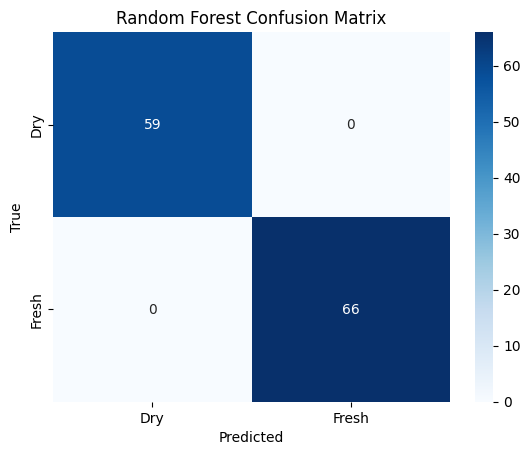


Logistic Regression Accuracy: 1.00
Logistic Regression ROC AUC: 1.00

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        66

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



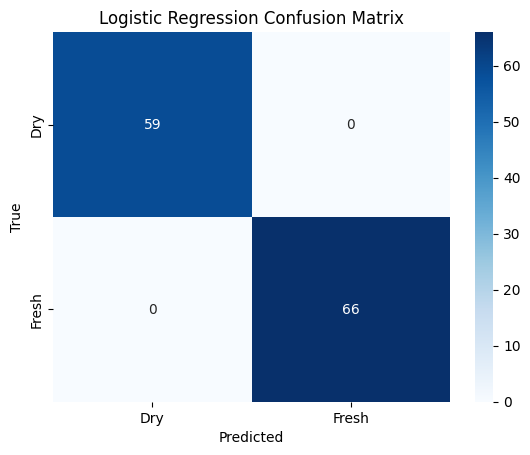


Gradient Boosting Accuracy: 1.00
Gradient Boosting ROC AUC: 1.00

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        66

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



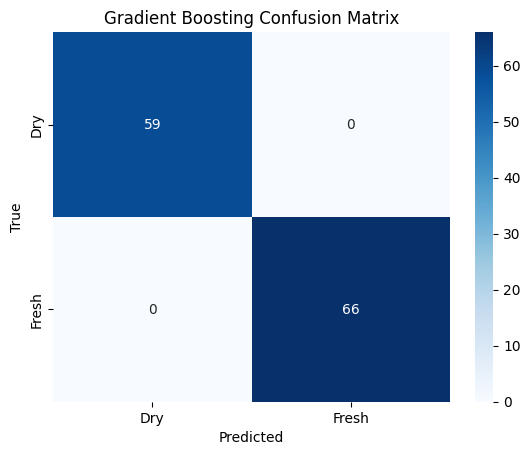

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Separate features (X) and target (y)
X = df.iloc[:, :-2]
y = df['is_fresh']


# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else None
    results[model_name] = {"Accuracy": acc, "ROC AUC": auc}
    print(f"\n{model_name} Accuracy: {acc:.2f}")
    if auc:
        print(f"{model_name} ROC AUC: {auc:.2f}")
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dry', 'Fresh'], yticklabels=['Dry', 'Fresh'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

## Step 8: Hyperparameter Tuning
#### Goal
Fine-tune the machine learning models to improve their performance by adjusting key parameters.

#### Explanation
We will use GridSearchCV to tune the hyperparameters of the Random Forest and Gradient Boosting models. This will help us find the best combination of parameters for optimal model performance.

In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Define reduced parameter grids
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Randomized search with reduced folds
random_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    n_iter=10,  # Evaluate 10 random combinations
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_gb = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit Random Forest
random_rf.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {random_rf.best_params_}")

# Fit Gradient Boosting
random_gb.fit(X_train, y_train)
print(f"Best parameters for Gradient Boosting: {random_gb.best_params_}")

# Evaluate best models
best_rf = random_rf.best_estimator_
best_gb = random_gb.best_estimator_

# Test on the test set
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

# Print Accuracy and Classification Report
print("\nRandom Forest after Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

print("\nGradient Boosting after Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(classification_report(y_test, y_pred_gb))


Best parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Gradient Boosting: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}

Random Forest after Hyperparameter Tuning:
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        66

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125


Gradient Boosting after Hyperparameter Tuning:
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        66

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



## Step 9: Learning Curves for Optimized Models
#### Goal
Visualize the training and validation performance of the optimized Random Forest (RF) and Gradient Boosting (GB) models as the training set size increases.

#### Explanation
Learning curves help identify if the models are overfitting, underfitting, or behaving as expected

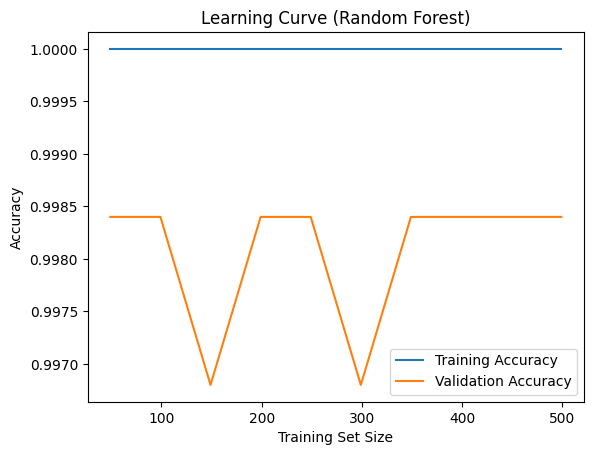

In [18]:

# Step 7: Learning Curve for Optimized RF (optional)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_scaled, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

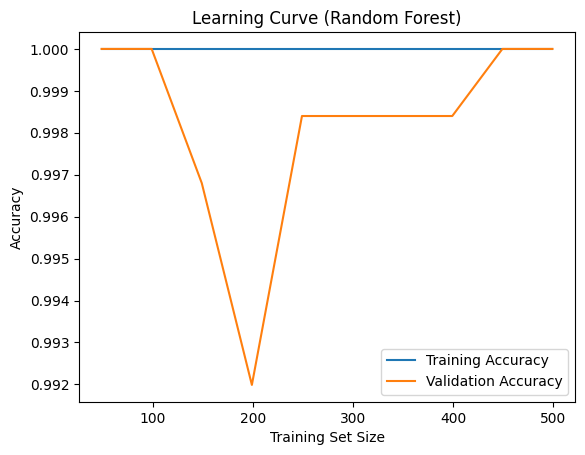

In [19]:

# Step 7: Learning Curve for Optimized GB (optional)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_gb, X_scaled, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Step 10: Final Model Evaluation
#### Goal
Evaluate the final model's performance on the test data and assess its robustness.

#### Explanation
We will now test the performance of the best-performing model (based on accuracy and ROC AUC score) on the test set to ensure that it generalizes well to unseen data.

Used Model: GradientBoostingClassifier

Final Model Accuracy: 1.0000
Final Model ROC AUC: 1.0000

Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        66

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



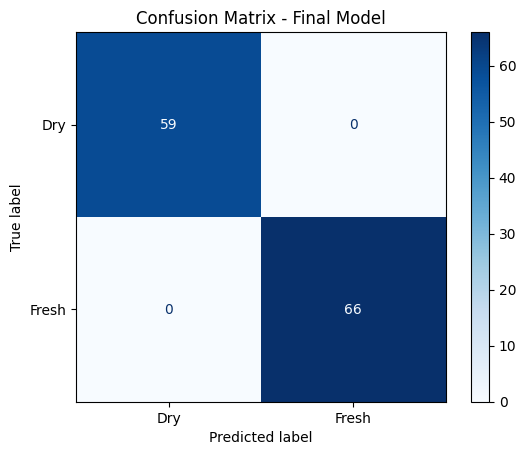

In [30]:
# Choose the best model (either based on GridSearchCV or initial performance)
final_model = best_rf if accuracy_score(y_test, y_pred_rf) > accuracy_score(y_test, y_pred_gb) else best_gb
final_model_name=str(final_model).split("(")[0]
# Predict with the final model
y_pred_final = final_model.predict(X_test)

# Final Model Evaluation
final_accuracy = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1]) if hasattr(final_model, "predict_proba") else None

# Display evaluation results
print(f"Used Model: {final_model_name}")
print(f"\nFinal Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model ROC AUC: {final_auc:.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final))

# Plot confusion matrix for final model
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Dry', 'Fresh'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Final Model")
plt.show()

#Dump Final Model
import pickle
# Save the final model to a file
with open('dry_fresh_final_model.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)

## Step 11: Model Deployment and Prediction on New Data
#### Goal
Deploy the trained model and use it to make predictions on new, unseen data.

#### Explanation
We will demonstrate how to use the trained model to make predictions on new samples, applying the same preprocessing steps (like scaling) to the new data.

In [58]:
# Example new data (you can replace this with actual data from an external source)
new_data=list(X_test[6].reshape(1, -1))
# Preprocessing the new data (standardizing it as we did with the training data)
new_data_scaled = scaler.transform(new_data)
# Make predictions on the new data
new_predictions = final_model.predict(new_data_scaled)

# Display the predictions (0 for dry, 1 for fresh)
print(f"Predictions on New Data: {new_predictions[0]}")
# Output the prediction
if new_predictions[0] == 1:
    print("The fruit is fresh.")
else:
    print("The fruit is dry.")

Predictions on New Data: 1
The fruit is fresh.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Step 12: Conclusion and Next Steps


### Conclusion

- The model successfully classifies the spectral data into fresh and dry samples.
- Random Forest and Gradient Boosting models performed well after hyperparameter tuning.
- Key features for classification were identified using feature importance scores.
- Future steps may include gathering more data, improving feature engineering, or exploring deep learning techniques for better accuracy.

### Next Steps
1. Implement model deployment in a cloud or edge environment.
2. Investigate time-series analysis if the data includes temporal elements.
3. Experiment with deep learning models for further improvements.


In [73]:
#@ Load model and try [max row numnber 624]
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
import pandas as pd
df_test = pd.read_csv('spectral_data.csv')
test = df_test.iloc[:, 0:2151]
# load the model back
with open('dry_fresh_final_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

def check_dry_fresh(row_number=623):
  new_data = list(test.iloc[row_number])

  # Ensure that the new data has the same length as the training data
  # Example: Assume training data had columns for wavelengths from 0 to 2150, with reflection values for each
  new_data = np.array(new_data).reshape(1, -1)  # Reshape it to 2D (1 sample, n features)

  # If you scaled your training data using StandardScaler, you should apply the same scaler to the new data.
  # Assuming we used StandardScaler during training:

  scaler = StandardScaler()  # Replace this with the scaler used during training, if it was saved
  new_data_scaled = scaler.fit_transform(new_data)  # Apply the same scaling

  # Predict using the loaded model
  prediction = loaded_model.predict(new_data_scaled)

  # Output the prediction
  if prediction == 1:
      print("The fruit is fresh.")
  else:
      print("The fruit is dry.")
Row_Number = 102  # @param {type: "number"}
check_dry_fresh(Row_Number)

The fruit is dry.
